In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import json
import seaborn as sns
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
#from src.utils.logger_functions import console
from src.cmos_plotter.Plotter_Helper_KV import *
from src.utils.metadata_functions import load_metadata_as_dataframe
import logging
import pickle
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [2]:
MAIN_PATH = f'/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart'
#metadata = load_metadata_as_dataframe(file_path = os.path.join(MAIN_PATH, ''))

In [11]:
PAIRINGS_PATH = os.path.join(MAIN_PATH, f'biTE_new/')
OUTPUT_PATH = os.path.join(MAIN_PATH,f'Results')
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [19]:
pickle_files = glob.glob(os.path.join(PAIRINGS_PATH, '*.pkl'))
pickle_files


['/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_new/ID2167_N6_DIV35_DATE20250418_1614_spontaneous_NGN2.raw_processed_info_metrics.pkl',
 '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_new/ID2167_N1_DIV19_DATE20250402_1301_spontaneous_NGN2.raw_processed_info_metrics.pkl',
 '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_new/ID2751_N2_DIV19_DATE20250402_1302_spontaneous_NGN2.raw_processed_info_metrics.pkl',
 '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_new/ID2816_N8_DIV32_DATE20250415_0917_spontaneous_NGN2.raw_processed_info_metrics.pkl',
 '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_new/ID2184_N2_DIV14_DATE20250328_0906_spontaneous_NGN2.raw_processed_info_metrics.p

In [20]:
results_combined = pd.DataFrame()
for pickle_file in pickle_files:
    filename = os.path.basename(pickle_file)
    print(filename)
    filename_parts = filename.split('_')
    chip_id = int(filename_parts[0].replace('ID', ''))
    div = int(filename_parts[2].replace('DIV', ''))
    area = filename_parts[1]

    data_te = np.load(pickle_file, allow_pickle=True)

    try:    

        filtered_data = data_te['validated_results']
        #print(filtered_data)

        for pair in filtered_data:
            if pair['validation'] == 'good':

            #make one big dataframe containing filename, chip_id, div, area, syn probability
                results_combined = pd.concat([results_combined, pd.DataFrame({
                    'filename': filename,
                    'chip_id': [chip_id],
                    'div': [div],
                    'area': [area],
                    'syn_probability': [pair['syn probability']],
                    'mTE': [pair['mTE']],
                    'lag': [pair['lag']],
                    'source_electrode': [pair['source_electrode']],
                    'target_electrode': [pair['target_electrode']],
                    'source_unit_id': [pair['source_unit_id']],
                    'target_unit_id': [pair['target_unit_id']]
                })], ignore_index=True)
    except KeyError:
        print(f"KeyError: 'validated_results' not found in {filename}")
        continue
with open(os.path.join(OUTPUT_PATH, 'results_combined_probabilites.pkl'), 'wb') as f:
    pickle.dump(results_combined, f)

ID2167_N6_DIV35_DATE20250418_1614_spontaneous_NGN2.raw_processed_info_metrics.pkl


ID2167_N1_DIV19_DATE20250402_1301_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2751_N2_DIV19_DATE20250402_1302_spontaneous_NGN2.raw_processed_info_metrics.pkl
KeyError: 'validated_results' not found in ID2751_N2_DIV19_DATE20250402_1302_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2816_N8_DIV32_DATE20250415_0917_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2184_N2_DIV14_DATE20250328_0906_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2751_N3_DIV19_DATE20250402_1302_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2816_N1_DIV21_DATE20250404_1107_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2167_N5_DIV26_DATE20250409_1028_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2816_N2_DIV19_DATE20250402_1220_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2751_N0_DIV21_DATE20250404_1147_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2167_N5_DIV32_DATE20250415_0918_spontaneous_NGN2.raw_processed_info_metrics.pkl
ID2167_N2_DIV32_DATE20250415_0918_spontaneous_NGN2.raw_

In [6]:
with open(os.path.join(OUTPUT_PATH, 'results_combined_probabilites.pkl'), 'rb') as f:
    results_combined = pickle.load(f)

In [77]:
def custom_lineplot(data, x_metric, y_metric, axes, label, fontsize=16, labelsize=14, xlim = None, ylim = None, save_path=None):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'    
    sns.lineplot(data=data, x=x_metric, y=y_metric, color="dimgrey", markers=True, estimator="mean", 
                 err_style="bars", legend=True, zorder=1, ax=axes, dashes=False, marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))        
    axes.set_ylabel(label, fontsize=fontsize)    
    axes.set_xlabel("Day In Vitro", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if save_path:
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.pdf'), dpi=300)
    

2025-05-08 14:50:37,340 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-08 14:50:37,354 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-08 14:50:37,355 Writing TrueType font.


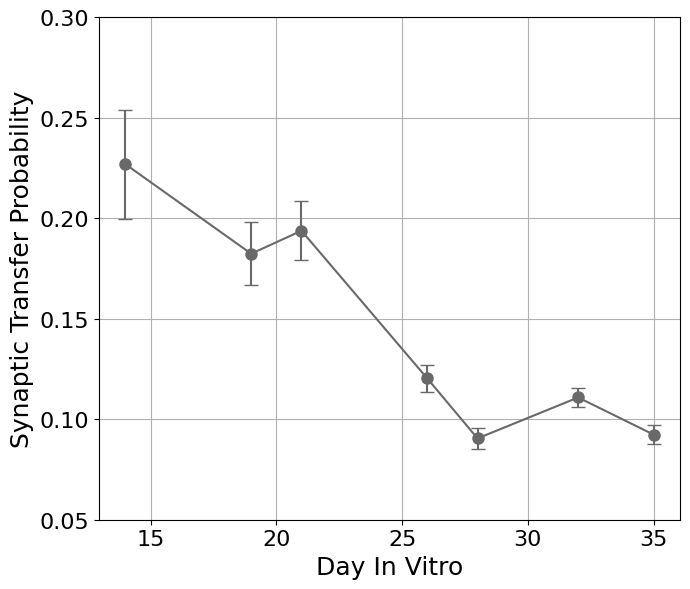

In [65]:
plt.figure(figsize=(7, 6))

results_combined = results_combined[results_combined['div'] > 10]
#probabilities = results_combined['syn_probability'].values
#speeds = speeds[speeds['div'].isin([23, 65, 107, 129, 147])]

# Calculate SEM for each DIV group
sem = results_combined.groupby('div')['syn_probability'].sem().reset_index(name='sem')
means = results_combined.groupby('div')['syn_probability'].mean().reset_index(name='mean_probability')
std = results_combined.groupby('div')['syn_probability'].std().reset_index(name='std')

# Merge the dataframes
plot_data = pd.merge(means, sem, on='div')

# Plot with error bars showing SEM
plt.errorbar(x=plot_data['div'], y=plot_data['mean_probability'], 
             yerr=plot_data['sem'], 
             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color = 'dimgray')
#sns.violinplot(data=results_combined, x='div', y='syn_probability', 
#               inner='quartile', density_norm='area', bw=0.5, alpha=0.5, color='dimgray')
#plt.title('Conduction speed vs Div')
plt.xlabel('Day In Vitro', fontsize = 18)
plt.ylabel('Synaptic Transfer Probability', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.05, 0.3)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'Syn_probability_vs_div.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'Syn_probability_vs_div.pdf'), dpi=300, format ='pdf')

plt.show()
#plt.figure(figsize=(10, 6))

2025-05-08 15:03:48,337 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-08 15:03:48,350 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-08 15:03:48,350 Writing TrueType font.


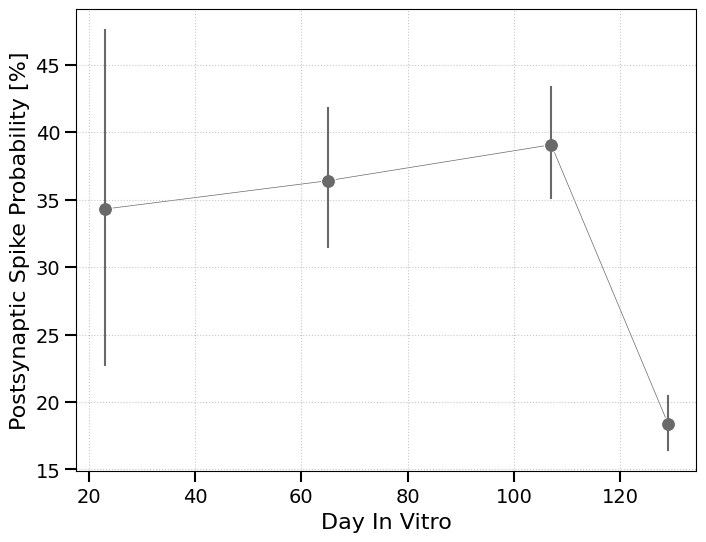

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
custom_lineplot(results_combined, results_combined['div'], results_combined['syn_probability']*100, ax, label = 'Postsynaptic Spike Probability [%]', fontsize=16, labelsize=14, xlim = None, ylim = None, save_path = OUTPUT_PATH)      

2025-05-05 17:11:36,906 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-05 17:11:36,910 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-05-05 17:11:37,089 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-05 17:11:37,104 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-05 17:11:37,104 Writing TrueType font.


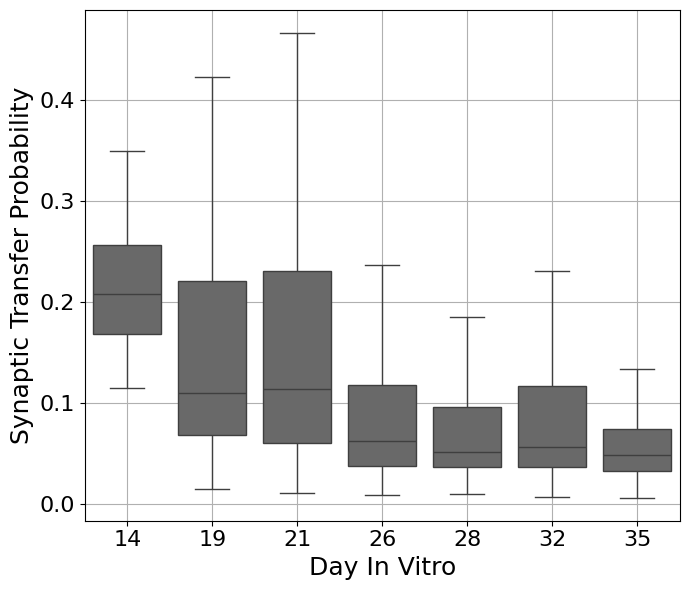

In [51]:
plt.figure(figsize=(7, 6))

#probabilities = results_combined['syn_probability'].values
#speeds = speeds[speeds['div'].isin([23, 65, 107, 129, 147])]

# Calculate SEM for each DIV group
sem = results_combined.groupby('div')['syn_probability'].sem().reset_index(name='sem')
means = results_combined.groupby('div')['syn_probability'].mean().reset_index(name='mean_probability')
std = results_combined.groupby('div')['syn_probability'].std().reset_index(name='std')

# Merge the dataframes
plot_data = pd.merge(means, sem, on='div')

# Plot with error bars showing SEM
#plt.errorbar(x=plot_data['div'], y=plot_data['mean_probability'], 
#             yerr=plot_data['sem'], 
#             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color = 'dimgray')
#sns.violinplot(data=results_combined, x='div', y='syn_probability', 
#               inner='quartile', density_norm='area', bw=0.5, alpha=0.5, color='dimgray')
sns.boxplot(data=results_combined, x='div', y='syn_probability', 
            color='dimgray',
            showfliers=False) 

plt.xlabel('Day In Vitro', fontsize = 18)
plt.ylabel('Synaptic Transfer Probability', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.1, 0.8)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'Syn_probability_vs_div_box.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'Syn_probability_vs_div_box.pdf'), dpi=300, format ='pdf')

plt.show()
#plt.figure(figsize=(10, 6))

2025-05-05 16:58:59,946 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-05 16:58:59,962 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-05 16:58:59,962 Writing TrueType font.


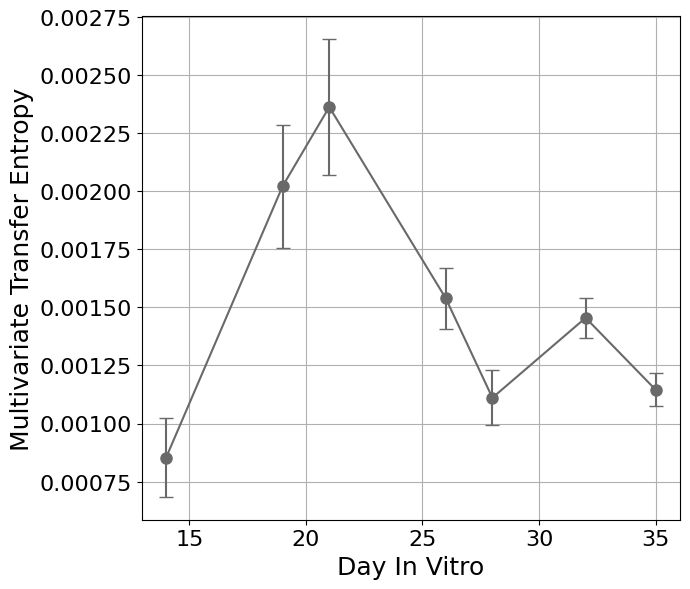

In [ ]:
plt.figure(figsize=(7, 6))

#probabilities = results_combined['syn_probability'].values
#speeds = speeds[speeds['div'].isin([23, 65, 107, 129, 147])]

# Calculate SEM for each DIV group
sem = results_combined.groupby('div')['mTE'].sem().reset_index(name='sem')
means = results_combined.groupby('div')['mTE'].mean().reset_index(name='mean_mTE')
std = results_combined.groupby('div')['mTE'].std().reset_index(name='std')

# Merge the dataframes
plot_data = pd.merge(means, sem, on='div')

# Plot with error bars showing SEM
plt.errorbar(x=plot_data['div'], y=plot_data['mean_mTE'], 
             yerr=plot_data['sem'], 
             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color = 'dimgray')

#plt.title('Conduction speed vs Div')
plt.xlabel('Day In Vitro', fontsize = 18)
plt.ylabel('Multivariate Transfer Entropy', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.3, 0.8)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'mTE_vs_div.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'mTE_vs_div.pdf'), dpi=300, format ='pdf')

plt.show()
#plt.figure(figsize=(10, 6))

2025-05-09 12:11:43,531 Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-09 12:11:43,532 Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-09 12:11:43,548 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 12:11:43,552 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 12:11:44,234 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-09 12:11:44,274 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-09 12:11:44,274 Writing Tru

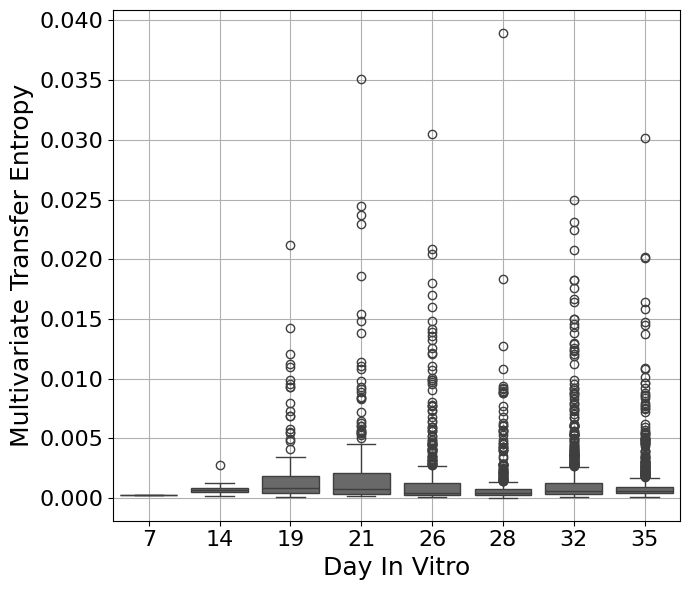

In [7]:
plt.figure(figsize=(7, 6))

#probabilities = results_combined['syn_probability'].values
#speeds = speeds[speeds['div'].isin([23, 65, 107, 129, 147])]

# Calculate SEM for each DIV group
sem = results_combined.groupby('div')['mTE'].sem().reset_index(name='sem')
means = results_combined.groupby('div')['mTE'].mean().reset_index(name='mean_mTE')
std = results_combined.groupby('div')['mTE'].std().reset_index(name='std')

# Merge the dataframes
plot_data = pd.merge(means, sem, on='div')

# Plot with error bars showing SEM
#plt.errorbar(x=plot_data['div'], y=plot_data['mean_mTE'], 
#             yerr=plot_data['sem'], 
#             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color = 'dimgray')
#sns.violinplot(data=results_combined, x='div', y='mTE', 
#               inner='quartile', density_norm='area', bw=0.5, alpha=0.5, color='dimgray')
sns.boxplot(data=results_combined, x='div', y='mTE', 
            color='dimgray',
            showfliers=True) 
#sns.stripplot(data=results_combined, x='div', y='mTE',
#              size=4, color='black', alpha=0.5,
#              jitter=True)

#plt.title('Conduction speed vs Div')
plt.xlabel('Day In Vitro', fontsize = 18)
plt.ylabel('Multivariate Transfer Entropy', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(-0.005, 0.02)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'mTE_vs_div_violin.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'mTE_vs_div_violin.pdf'), dpi=300, format ='pdf')

plt.show()

2025-05-08 15:04:10,648 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-08 15:04:10,650 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-05-08 15:04:10,844 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-08 15:04:10,855 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-08 15:04:10,855 Writing TrueType font.


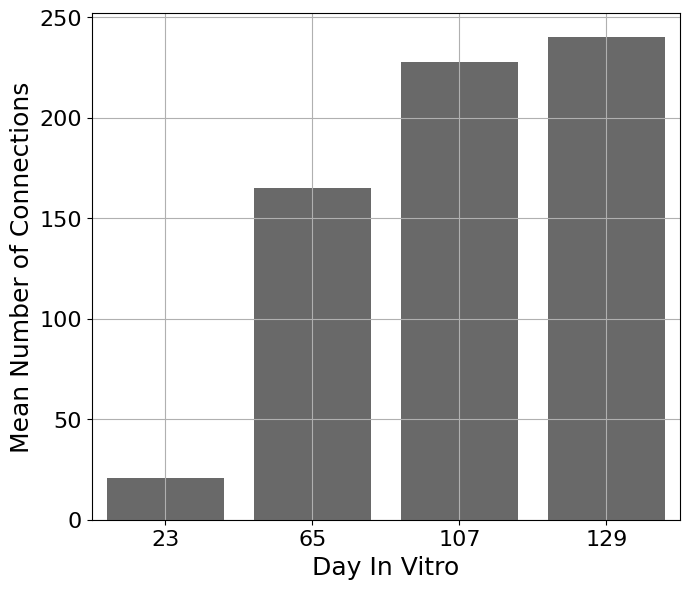

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Assuming results_combined is your dataframe with columns 'div', 'chip_id', etc.
df = results_combined

# Step 1: Count rows for each chip_id in each div
# Group by div and chip_id, then count the number of rows in each group
row_counts = df.groupby(['div', 'chip_id']).size().reset_index(name='row_count')

# Step 2: Calculate statistics across chips
# Calculate mean row count per div across all chips
mean_counts_per_div = row_counts.groupby('div')['row_count'].mean().reset_index()
mean_counts_per_div.rename(columns={'row_count': 'mean_rows'}, inplace=True)

# Calculate standard error of mean (SEM) for each div
sem = row_counts.groupby('div')['row_count'].sem().reset_index()
sem.rename(columns={'row_count': 'sem'}, inplace=True)

# Step 3: Plotting
plt.figure(figsize=(7, 6))

# Merge the dataframes 
plot_data = pd.merge(mean_counts_per_div, sem, on='div')

# Plot with error bars showing SEM
#plt.errorbar(x=plot_data['div'], y=plot_data['mean_rows'],
#             yerr=plot_data['sem'],
#             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color='dimgray')
sns.barplot(data=plot_data, x='div', y='mean_rows', 
            yerr=plot_data['sem'], capsize=.2, color='dimgray')


plt.xlabel('Day In Vitro', fontsize=18)
plt.ylabel('Mean Number of Connections', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(OUTPUT_PATH, 'mean_rows_vs_div.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'mean_rows_vs_div.pdf'), dpi=300, format='pdf')

plt.show()

In [5]:
def multi_dataframe_lineplot(data_list, x_metrics, y_metrics, axes, labels, colors, fontsize=16, labelsize=14, xlim=None, ylim=None, save_path=None, log_scale=False):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'
    
    # Plot each dataframe with its own color
    for data, x_metric, y_metric, label, color in zip(data_list, x_metrics, y_metrics, labels, colors):
        sns.lineplot(data=data, x=x_metric, y=y_metric, color=color, markers=True, estimator="mean", 
                    err_style="bars", label=label, zorder=1, ax=axes, dashes=False, 
                    marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))
    
    # Set common axes properties
    axes.set_ylabel(labels[0], fontsize=fontsize)  # Using the first label for y-axis title
    axes.set_xlabel("Day In Vitro", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    #axes.legend()
    
    if log_scale:
        axes.set_xscale('log')  # Set x-axis to log scale
    

    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    
    if save_path:
        plt.savefig(os.path.join(save_path, f'{labels[0][:10]}.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'{labels[0][:10]}.pdf'), dpi=300)

In [2]:

MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Pickle_files_1851'
OUTPUT_PATH = os.path.join(MAIN_PATH, f'Results/')
with open(os.path.join(OUTPUT_PATH, 'results_combined_probabilites.pkl'), 'rb') as f:
   df_1 = pickle.load(f)
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart'
OUTPUT_PATH = os.path.join(MAIN_PATH, f'Results/')
with open(os.path.join(OUTPUT_PATH, 'results_combined_probabilites.pkl'), 'rb') as f:
   df_2 = pickle.load(f)

2025-05-15 17:38:05,753 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-15 17:38:05,753 ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
2025-05-15 17:38:05,754 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-15 17:38:05,754 ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
2025-05-15 17:38:05,755 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-15 17:38:05,755 ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
2025-05-15 17:38:05,778 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-15 17:38:05,778 ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
2025-05-15 17:38:05,779 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-

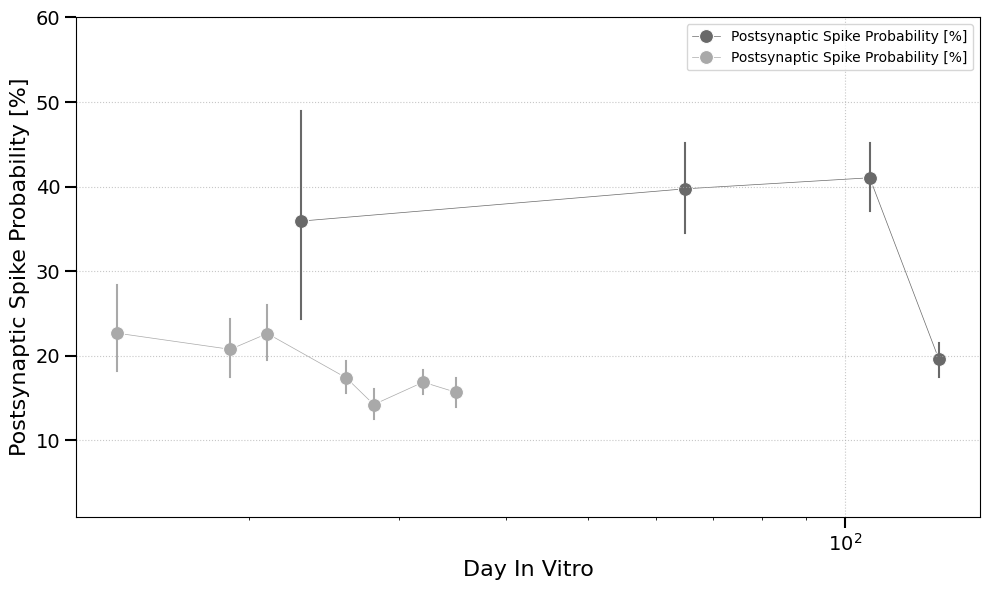

In [36]:
# Filter data if needed (like in your example with speeds)
df_1 = pd.DataFrame(df_1)
df_2 = pd.DataFrame(df_2)
df_1 = df_1[df_1['syn_probability'] > 0.05]
df_2 = df_2[df_2['syn_probability'] > 0.05]
df_2 = df_2[df_2['div'] > 10]
df_1 = df_1[df_1['div'].isin([23, 65, 107, 129, 147])]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors - dimgray for first and a lighter gray for second
colors = ['dimgray', '#A9A9A9']  # dimgray and darkgray

# Call the modified function with both dataframes
multi_dataframe_lineplot(
    data_list=[df_1, df_2],
    x_metrics=[df_1['div'], df_2['div']],
    y_metrics=[df_1['syn_probability']*100, df_2['syn_probability']*100],
    axes=ax,
    labels=['Postsynaptic Spike Probability [%]', 'Postsynaptic Spike Probability [%]'],
    colors=colors,
    fontsize=16, 
    labelsize=14, 
    xlim=None, 
    ylim=(1, 60), 
    save_path=OUTPUT_PATH,
    log_scale=True
)

plt.tight_layout()

In [3]:
df_1 = pd.DataFrame(df_1)
df_2 = pd.DataFrame(df_2)
df_1 = df_1[df_1['syn_probability'] > 0.05]
df_2 = df_2[df_2['syn_probability'] > 0.05]
df_2 = df_2[df_2['div'] > 10]
df_1 = df_1[df_1['div'].isin([23, 65, 107, 129, 147])]
row_counts_1 = df_1.groupby(['div', 'chip_id']).size().reset_index(name='row_count')
row_counts_2 = df_2.groupby(['div', 'chip_id']).size().reset_index(name='row_count')

2025-05-16 10:32:43,615 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-16 10:32:43,615 ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
2025-05-16 10:32:43,616 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-16 10:32:43,616 ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
2025-05-16 10:32:43,617 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-16 10:32:43,617 ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
2025-05-16 10:32:43,680 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-16 10:32:43,681 ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
2025-05-16 10:32:43,681 vmin 12.528669471981264 vmax 144.14938505951358
2025-05-

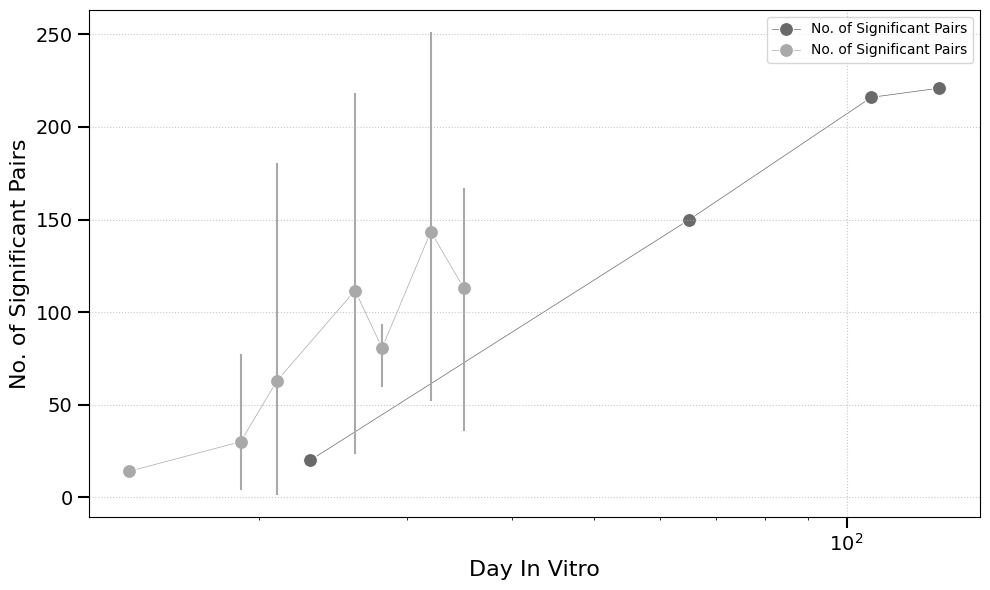

In [6]:
# Filter data if needed (like in your example with speeds)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors - dimgray for first and a lighter gray for second
colors = ['dimgray', '#A9A9A9']  # dimgray and darkgray

# Call the modified function with both dataframes
multi_dataframe_lineplot(
    data_list=[row_counts_1, row_counts_2],
    x_metrics=[row_counts_1['div'], row_counts_2['div']],
    y_metrics=[row_counts_1['row_count'], row_counts_2['row_count']],
    axes=ax,
    labels=['No. of Significant Pairs', 'No. of Significant Pairs'],
    colors=colors,
    fontsize=16, 
    labelsize=14, 
    xlim=None, 
    #ylim=(0.01, 0.6), 
    save_path=OUTPUT_PATH,
    log_scale=True
)

plt.tight_layout()

In [61]:
def custom_bar(data, x_metric, y_metric, axes, label, fontsize=16, labelsize=14):        
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'    
    sns.barplot(data=data, x=x_metric, y=y_metric, color="dimgrey", ax=axes, errorbar="se")        
    axes.set_ylabel(label, fontsize=fontsize)    
    axes.set_xlabel("Day In Vitro", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    plt.savefig(os.path.join(OUTPUT_PATH, f'{label}.png'), dpi=300)
    plt.savefig(os.path.join(OUTPUT_PATH, f'{label}.pdf'), dpi=300)

2025-05-08 15:04:18,807 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-08 15:04:18,819 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-08 15:04:18,819 Writing TrueType font.


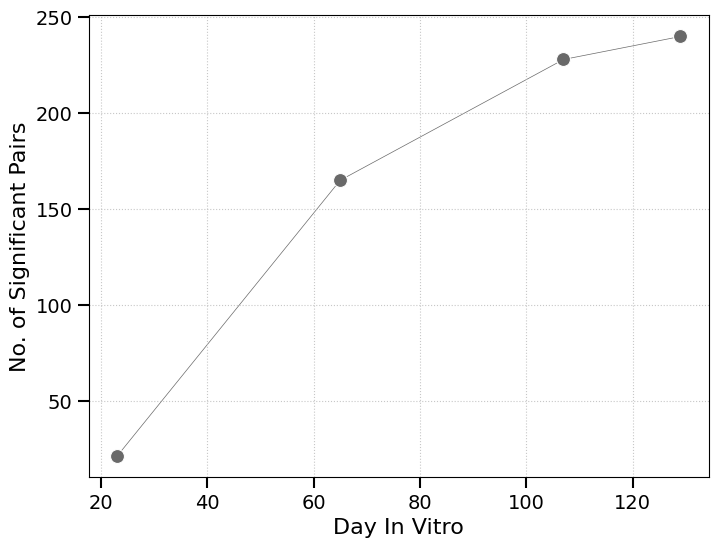

In [81]:
fig, ax = plt.subplots(figsize=(8,6))
custom_lineplot(row_counts, row_counts['div'], row_counts['row_count'], ax, label = 'No. of Significant Pairs', fontsize=16, labelsize=14, save_path= OUTPUT_PATH)

In [7]:
with open(os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/CSVs/validated_results_full_data_w_speed_and_firing.pkl'), 'rb') as f:
    all_data  = pd.read_pickle(f)


In [5]:
all_data = all_data[all_data['syn probability'] > 0.01]

In [8]:
all_latency = all_data['latency_extremum'][(all_data['Stimulation_frequency'] == '10_Hz') & (all_data['Delay'] == '0_ms')].copy()
all_lag = all_data['lag'][(all_data['Stimulation_frequency'] == '10_Hz') & (all_data['Delay'] == '0_ms')].copy()

In [9]:
all_latency = all_latency.reset_index(drop=True)
all_lag = all_lag.reset_index(drop=True)
len(all_latency), len(all_lag)

(606, 606)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_synaptic_probability_over_time(all_latency, all_lag, bin_size=30000, label = '10 Hz'):
    """
    Calculate and plot the mean synaptic probability over time, binned in 30-second intervals.
    
    Parameters:
    -----------
    all_latency : pandas.Series
        Series where each element is a structured array with fields:
        ('input spike', '<i4'), ('spike time', '<f8'), ('latency', '<f4'), ('category', '<U6')
    all_lag : pandas.Series
        Series of lag values corresponding to each row in all_latency
    bin_size : int, default=30
        Size of time bins in seconds
    
    Returns:
    --------
    tuple
        (bin_centers, mean_probabilities, figure)
    """
    # Find the maximum spike time across all rows to determine the number of bins
    max_time = max(np.max(latency['spike time']) for latency in all_latency)
    num_bins = int(np.ceil(max_time / bin_size))
    bin_edges = np.arange(0, (num_bins + 1) * bin_size, bin_size)
    bin_centers = bin_edges[:-1] + bin_size/2
    
    # Initialize a 2D array to store probabilities per row per bin
    # (rows = different all_latency entries, columns = time bins)
    all_probabilities = np.full((len(all_latency), num_bins), np.nan)
    
    # 1) For each row in all_latency:
    for i in range(len(all_latency)):
        latency = all_latency[i]
        lag = all_lag[i]
        
        # 2) For each time bin:
        for bin_idx in range(num_bins):
            bin_start = bin_edges[bin_idx]
            bin_end = bin_edges[bin_idx+1]
            
            # Get spikes in this bin
            bin_mask = (latency['spike time'] >= bin_start) & (latency['spike time'] < bin_end)
            bin_latency = latency[bin_mask]
            
            # Skip if no spikes in this bin
            if len(bin_latency) == 0:
                continue
            
            # Skip if no input spikes in this bin
            input_spike_counts = np.sum(bin_latency['category'] == 'input')
            if input_spike_counts == 0:
                continue
                
            # Calculate synaptic probability using the provided formula
            data_output = bin_latency[bin_latency['category'] == 'output']
            latency_filtered = data_output[(data_output['latency'] >= lag - 1) & 
                                         (data_output['latency'] <= lag + 1)]
            
            input_spikes = bin_latency['input spike'][bin_latency['category'] == 'input']
            output_spike_counts = np.sum(np.isin(latency_filtered['input spike'], input_spikes))
            
            # Calculate probability and store it for this row and bin
            probability = output_spike_counts / input_spike_counts
            all_probabilities[i, bin_idx] = probability
    
    # 3) Calculate mean probability across rows for each time bin
    mean_probabilities = np.nanmean(all_probabilities, axis=0)
    
    # 4) Create and return the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Only plot bins that have valid data
    valid_indices = ~np.isnan(mean_probabilities)
    
    ax.plot(bin_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            'o-', color='royalblue', linewidth=2, markersize=6)
    ax.set_xlim(0, 200)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    ax.set_title(f'Mean Synaptic Probability Over Time ({bin_size/1000}s bins)', fontsize=14)
    ax.grid(True, alpha=0.3)
    

    
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    return bin_centers, mean_probabilities, fig

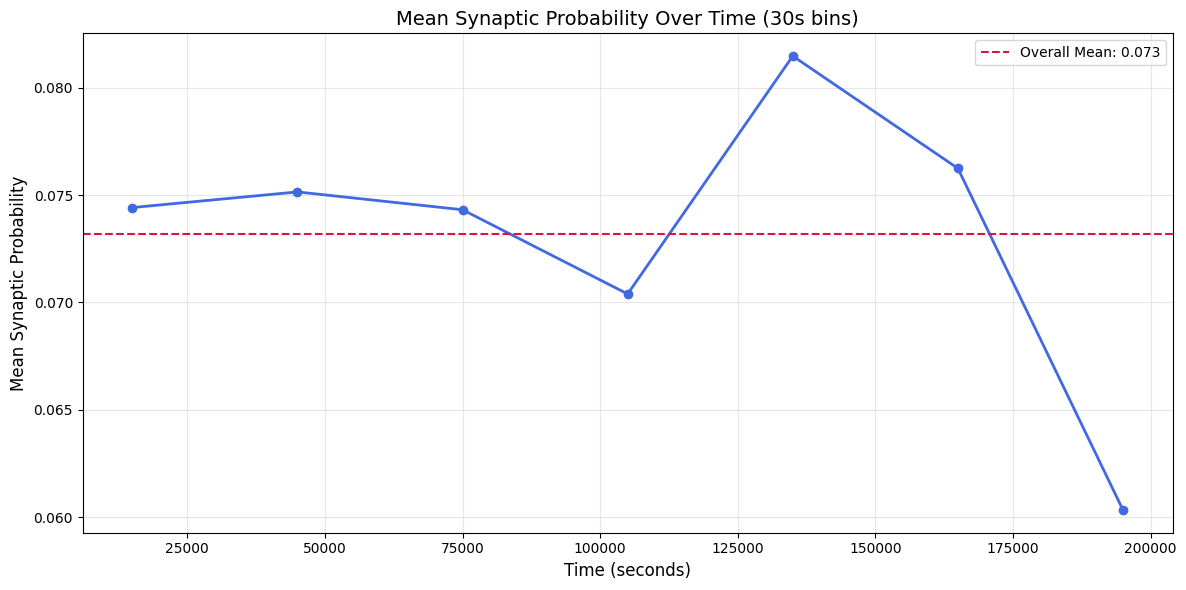

In [94]:
all_latency_to_plot = all_latency[:100]
all_lag_to_plot = all_lag[:100]
bin_centers, mean_probabilities, fig = calculate_synaptic_probability_over_time(all_latency_to_plot, all_lag_to_plot, bin_size=30000)


In [25]:
def calculate_synaptic_probability_rolling_window(all_latency, all_lag, window_size=30000, step_size=5000, label = '10 Hz', max_time = None):
    """
    Calculate and plot the mean synaptic probability over time using a rolling window approach.
    
    Parameters:
    -----------
    all_latency : pandas.Series
        Series where each element is a structured array with fields:
        ('input spike', '<i4'), ('spike time', '<f8'), ('latency', '<f4'), ('category', '<U6')
    all_lag : pandas.Series
        Series of lag values corresponding to each row in all_latency
    window_size : int, default=30000
        Size of the rolling window in milliseconds (30 seconds)
    step_size : int, default=5000
        Step size for moving the window in milliseconds (5 seconds)
    
    Returns:
    --------
    tuple
        (window_centers, mean_probabilities, figure)
    """
    if max_time is None:
        # Find the maximum spike time across all rows
        max_time = max(np.max(latency['spike time']) for latency in all_latency)
    else:
        max_time = max_time
    # Create rolling windows
    start_times = np.arange(0, max_time - window_size + step_size, step_size)
    window_centers = start_times + window_size / 2
    num_windows = len(start_times)
    
    # Initialize array to store probabilities for each row and window
    all_probabilities = np.full((len(all_latency), num_windows), np.nan)
    
    # Process each row
    for i in range(len(all_latency)):
        latency = all_latency[i]
        lag = all_lag[i]
        
        # Process each window
        for w_idx, start_time in enumerate(start_times):
            end_time = start_time + window_size
            
            # Get spikes in this window
            window_mask = (latency['spike time'] >= start_time) & (latency['spike time'] < end_time)
            window_latency = latency[window_mask]
            
            # Skip if no spikes or no input spikes in this window
            if len(window_latency) == 0:
                continue
                
            input_spike_counts = np.sum(window_latency['category'] == 'input')
            if input_spike_counts == 0:
                continue
            
            # Calculate synaptic probability using the provided formula
            data_output = window_latency[window_latency['category'] == 'output']
            latency_filtered = data_output[(data_output['latency'] >= lag - 1) & 
                                         (data_output['latency'] <= lag + 1)]
            
            input_spikes = window_latency['input spike'][window_latency['category'] == 'input']
            output_spike_counts = np.sum(np.isin(latency_filtered['input spike'], input_spikes))
            
            # Calculate and store probability for this row and window
            probability = output_spike_counts / input_spike_counts
            all_probabilities[i, w_idx] = probability
    
    # Calculate mean probability across rows for each window
    mean_probabilities = np.nanmean(all_probabilities, axis=0)
    
    # Create and return the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Only plot windows that have valid data
    valid_indices = ~np.isnan(mean_probabilities)
    
    ax.plot(window_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            '-', color='royalblue', linewidth=2)
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    #ax.set_ylim(0.2,0.5)
    #ax.set_xlim(0, 200)
    ax.set_title(f'Mean Synaptic Probability Over Time (Rolling Window: {window_size/1000}s, Step: {step_size/1000}s)', 
                 fontsize=14)
    ax.grid(True, alpha=0.3)
    

    
    # Add confidence interval
    if np.sum(valid_indices) > 2:  # Only if we have enough data points
        sem = np.nanstd(all_probabilities, axis=0) / np.sqrt(np.sum(~np.isnan(all_probabilities), axis=0))
        sem = sem[valid_indices]
        
        ax.fill_between(
            window_centers[valid_indices]/1000,
            mean_probabilities[valid_indices] - sem,
            mean_probabilities[valid_indices] + sem,
            alpha=0.2,
            color='royalblue',
            label='±1 SEM'
        )
    
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'Syn_probability_rolling_window_{label}.png'), dpi=300)
    
    return window_centers, mean_probabilities, all_probabilities, fig

In [4]:
with open(os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/CSVs/validated_results_full_data_w_speed_and_firing.pkl'), 'rb') as f:
    all_data  = pd.read_pickle(f)


In [5]:
frequencies = [5]
all_data = all_data[all_data['syn probability'] > 0.05]

#max_time = max(np.max(latency['spike time']) for latency in all_data['latency_extremum'])

In [6]:
all_data

,source_electrode,target_electrode,source_unit_id,target_unit_id,lag,validation,mTE,syn probability,latency_extremum,electrodes_source_unit,...,source_firing_rate,target_firing_rate,source_isi_mean,target_isi_mean,source_isi_median,target_isi_median,source_isi_std,target_isi_std,source_isi_cv,target_isi_cv
9,18095,18095,94,90,1.0,good,0.000288,0.403226,"[[0, 1219.1499999999999, 0.0, input], [1, 2327...","[18972, 18313, 20955, 20075, 19414, 18753, 209...",...,1.727585,5.208787,580.715858,192.1875,512.05,95.975,454.663174,237.749568,0.782936,1.237071
16,22494,21834,69,13,1.0,good,0.001189,0.101064,"[[0, 477.6, 0.0, input], [1, 1160.300000000000...","[20955, 20075, 19414, 20953, 21174, 21616, 189...",...,2.083595,0.284216,481.2196,3588.824,327.05,2897.8,459.519935,2340.361609,0.954907,0.652125
21,18095,18095,90,106,1.0,good,0.001462,0.159405,"[[0, 221.70000000000002, 0.0, input], [1, 222....","[18972, 18313, 20736, 20955, 20075, 19858, 194...",...,5.208787,2.46906,192.1875,405.922584,95.975,313.95,237.749568,396.495177,1.237071,0.976775
22,18095,18095,98,106,1.0,good,0.000690,0.148244,"[[0, 222.55, 0.0, input], [1, 223.0, 0.0, inpu...","[18972, 18313, 20736, 20077, 20075, 19858, 194...",...,4.272915,2.46906,234.336979,405.922584,107.025,313.95,283.659177,396.495177,1.210476,0.976775
23,18095,18095,94,106,1.0,good,0.000245,0.164516,"[[0, 1219.1499999999999, 0.0, input], [1, 2327...","[18972, 18313, 20955, 20075, 19414, 18753, 209...",...,1.727585,2.46906,580.715858,405.922584,512.05,313.95,454.663174,396.495177,0.782936,0.976775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26282,4755,9593,90,63,2.0,good,0.000845,0.201581,"[[0, 67.8, 0.0, input], [0, 70.35, 2.55, outpu...","[8933, 4318, 4756, 11573, 4316, 4096, 8494, 49...",...,1.525527,2.848737,658.1125,351.770273,136.0,209.9,1221.174627,522.662658,1.855571,1.485807
26285,12465,5215,12,84,6.0,good,0.002543,0.477157,"[[0, 1138.9499999999998, 0.0, input], [0, 1145...","[11804, 9825, 12023, 2566, 6966, 6086, 8066, 5...",...,1.181557,5.350648,850.658929,187.101842,446.325,83.525,1441.275667,263.743289,1.694305,1.409624
26288,14226,4098,10,78,4.0,good,0.002763,0.260664,"[[0, 158.65, 0.0, input], [1, 417.85, 0.0, inp...","[14226, 21050, 13785, 20392, 19293, 19954, 155...",...,2.513267,0.712735,398.83361,1414.936441,375.15,1029.325,227.705571,1149.667554,0.570929,0.812522
26290,1908,1908,88,7,2.0,good,0.001545,0.115974,"[[0, 180.35000000000002, 0.0, input], [1, 310....","[11147, 4547, 7627, 2566, 9168, 6528, 8508, 16...",...,2.727022,0.541735,367.504496,1866.660674,299.775,1069.65,554.903899,2872.812364,1.509924,1.539012


In [23]:
print(all_data['source_electrode'].unique()[0])

18095


Frequency before contains filenames ['ID2184_7_DIV32_DATE20250415_1156_spontaneous_Freq_variation_try_2.raw_processed_info_metrics.pkl']
Frequency after contains filenames ['ID2184_7_DIV32_DATE20250415_1207_spontaneous_Freq_variation_try_2.raw_processed_info_metrics.pkl']
Frequency after_2 contains filenames ['ID2184_7_DIV32_DATE20250415_1207_spontaneous_Freq_variation_try_2_0.raw_processed_info_metrics.pkl']


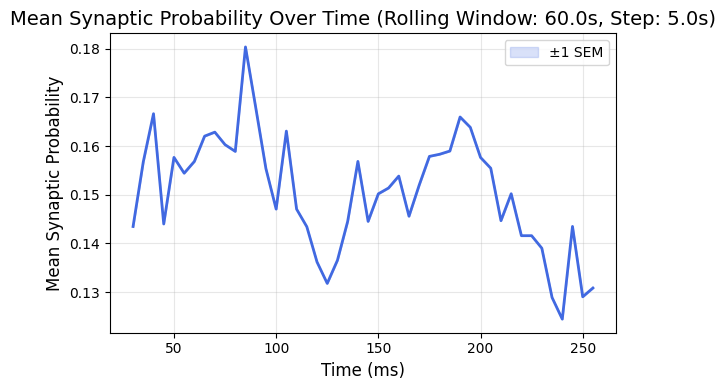

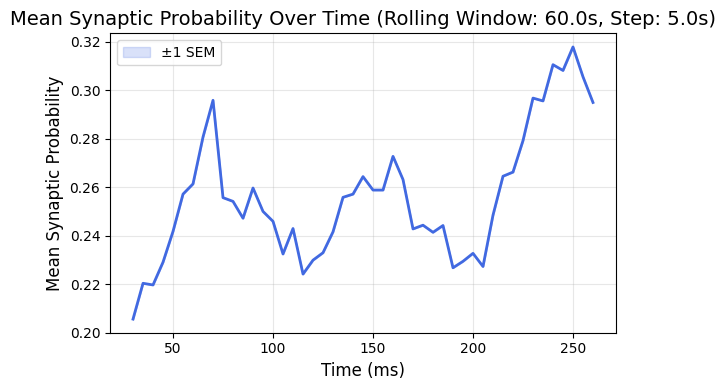

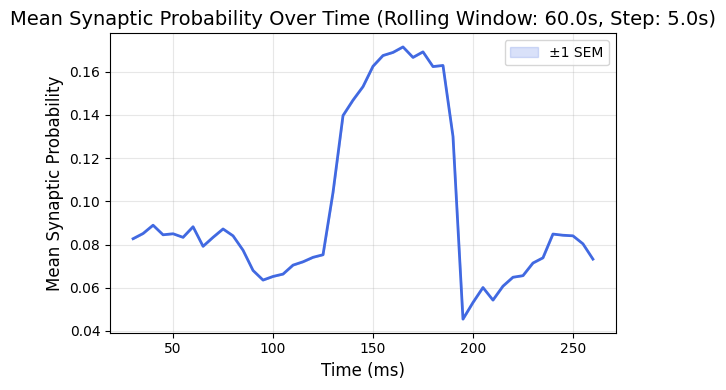

In [37]:
all_window_centers = []
all_mean_probabilities = []
all_all_probabilities = []
times = ['before', 'after', 'after_2']	
times_2 = [ 'after', 'after_2']
for time in times:
    filt_data = all_data[(all_data['Stimulation_frequency'] == f'5_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == f'{time}')]
    filt_data = filt_data[filt_data['Chip_ID'] == 'ID2184']
    if time == 'before':
        filt_data = filt_data[filt_data['source_electrode'] == 1531]
        filt_data = filt_data[filt_data['target_electrode'] == 19134]
    if time == 'after':
        filt_data = filt_data[filt_data['source_electrode'] == 1531]
        filt_data = filt_data[filt_data['target_electrode'] == 19354]
    if time == 'after_2':
        filt_data = filt_data[filt_data['source_electrode'] == 1531]
        filt_data = filt_data[filt_data['target_electrode'] == 19569]

    all_latency = filt_data['latency_extremum']
    all_lag = filt_data['lag']
    print(f"Frequency {time} contains filenames {filt_data['filename'].unique()}")
    all_latency = all_latency.reset_index(drop=True)
    all_lag = all_lag.reset_index(drop=True)
    
    window_centers, mean_probabilities, all_probabilities, fig = calculate_synaptic_probability_rolling_window(all_latency, all_lag, window_size=60000, step_size=5000, label = f'5 Hz')
    #window_center_bin, mean_probabilities_bin, fig_bin = calculate_synaptic_probability_over_time(all_latency, all_lag, bin_size=30000,label = f'{frequency} Hz')
    all_window_centers.append(window_centers)
    all_mean_probabilities.append(mean_probabilities)
    all_all_probabilities.append(all_probabilities)


In [ ]:
ex_xaxis = np.concatenate((np.array(all_window_centers[1]), np.array(all_window_centers[2]) + 235000))
ex_yaxis = np.concatenate((np.array(all_mean_probabilities[1]), np.array(all_mean_probabilities[2])))
sem_1 = np.nanstd(np.array(all_all_probabilities[1]), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(all_all_probabilities[1])), axis=0))
sem_2 = np.nanstd(np.array(all_all_probabilities[2]), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(all_all_probabilities[2])), axis=0))
sem_all = np.concatenate((sem_1, sem_2))
ex_yaxis = ex_yaxis[~np.isnan(ex_yaxis)]
ex_xaxis = ex_xaxis[~np.isnan(ex_yaxis)]
plt.figure(figsize=(6, 4))
plt.fill_between(
    ex_xaxis/1000,
    (ex_yaxis - sem_all)*100,
    (ex_yaxis + sem_all)*100,
    alpha=0.2,
    color='dimgray',
    label='±1 SEM'
)
plt.plot(ex_xaxis/1000, ex_yaxis*100, 'o-', color='dimgray', linewidth=2, markersize=6)
plt.grid(True, alpha=0.3)
plt.xlabel('Time [s]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Postsyn. Spike Probability [%]', fontsize=16)
plt.ylim(0.0,50)
plt.savefig(os.path.join(OUTPUT_PATH, f'Syn_probability_rolling_window_5Hz_after_after2.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'Syn_probability_rolling_window_5Hz_after_after2.pdf'), dpi=300, format='pdf')
plt.show()

IndexError: list index out of range

2025-06-02 20:34:30,404 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-06-02 20:34:30,417 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-06-02 20:34:30,417 Writing TrueType font.


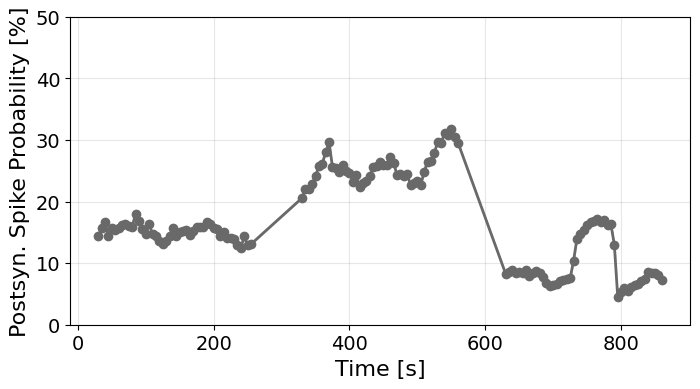

In [39]:
ex_xaxis = np.concatenate((np.array(all_window_centers[0]), np.array(all_window_centers[1]) + 300000, np.array(all_window_centers[2]) + 600000))
ex_yaxis = np.concatenate((np.array(all_mean_probabilities[0]), np.array(all_mean_probabilities[1]), np.array(all_mean_probabilities[2])))
sem_1 = np.nanstd(np.array(all_all_probabilities[0]), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(all_all_probabilities[0])), axis=0))
sem_2 = np.nanstd(np.array(all_all_probabilities[1]), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(all_all_probabilities[1])), axis=0))
sem_3 = np.nanstd(np.array(all_all_probabilities[2]), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(all_all_probabilities[2])), axis=0))
sem_all = np.concatenate((sem_1, sem_2, sem_3))
ex_yaxis = ex_yaxis[~np.isnan(ex_yaxis)]
ex_xaxis = ex_xaxis[~np.isnan(ex_yaxis)]
plt.figure(figsize=(8, 4))
plt.fill_between(
    ex_xaxis/1000,
    (ex_yaxis - sem_all)*100,
    (ex_yaxis + sem_all)*100,
    alpha=0.2,
    color='dimgray',
    label='±1 SEM'
)
plt.plot(ex_xaxis/1000, ex_yaxis*100, 'o-', color='dimgray', linewidth=2, markersize=6)
plt.grid(True, alpha=0.3)
plt.xlabel('Time [s]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Postsyn. Spike Probability [%]', fontsize=16)
plt.ylim(0.0,50)
plt.savefig(os.path.join(OUTPUT_PATH, f'Syn_probability_rolling_window_5Hz_before.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'Syn_probability_rolling_window_5Hz_before.pdf'), dpi=300, format='pdf')
plt.show()

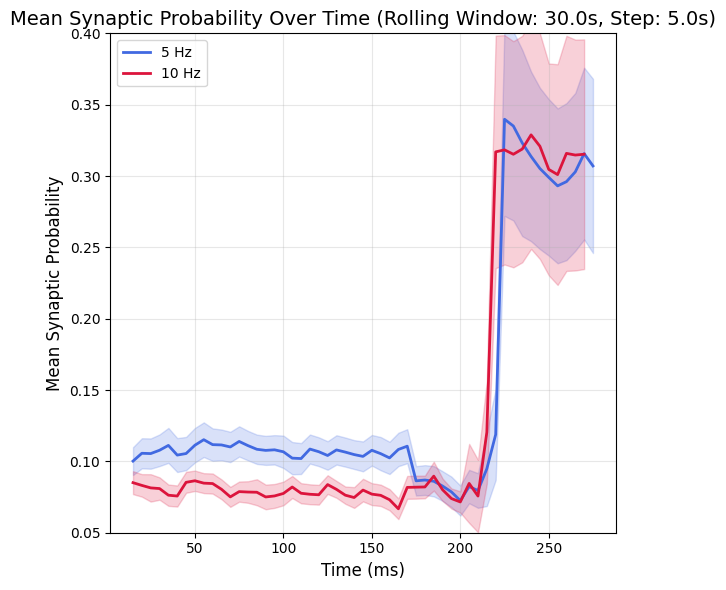

In [12]:
window_size = 30000
step_size = 5000
colors = ['royalblue', 'crimson']
 # Create and return the plot
fig, ax = plt.subplots(figsize=(6, 6))
for i, frequency in enumerate(frequencies_ltd):
    window_centers = all_window_centers[i]
    mean_probabilities = all_mean_probabilities[i]
    all_probabilities = all_all_probabilities[i]
    
   

    # Only plot windows that have valid data
    valid_indices = ~np.isnan(mean_probabilities)

    ax.plot(window_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            '-', color=colors[i], linewidth=2, label=f'{frequency} Hz')

    ax.set_xlabel('Time (ms)', fontsize=12)
    #ax.set_xlim(175, 210)
    ax.set_ylim(0.05,0.40)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    #ax.set_ylim(0.1,0.3)
    ax.set_title(f'Mean Synaptic Probability Over Time (Rolling Window: {window_size/1000}s, Step: {step_size/1000}s)', 
                fontsize=14)
    ax.grid(True, alpha=0.3) 
    # Add confidence interval
    if np.sum(valid_indices) > 2:  # Only if we have enough data points
        sem = np.nanstd(all_probabilities, axis=0) / np.sqrt(np.sum(~np.isnan(all_probabilities), axis=0))
        sem = sem[valid_indices]
        ax.fill_between(
            window_centers[valid_indices]/1000,
            mean_probabilities[valid_indices] - sem,
            mean_probabilities[valid_indices] + sem,
            alpha=0.2,
            color=colors[i],
            #label='±1 SEM'
        )
    
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()

plt.show()

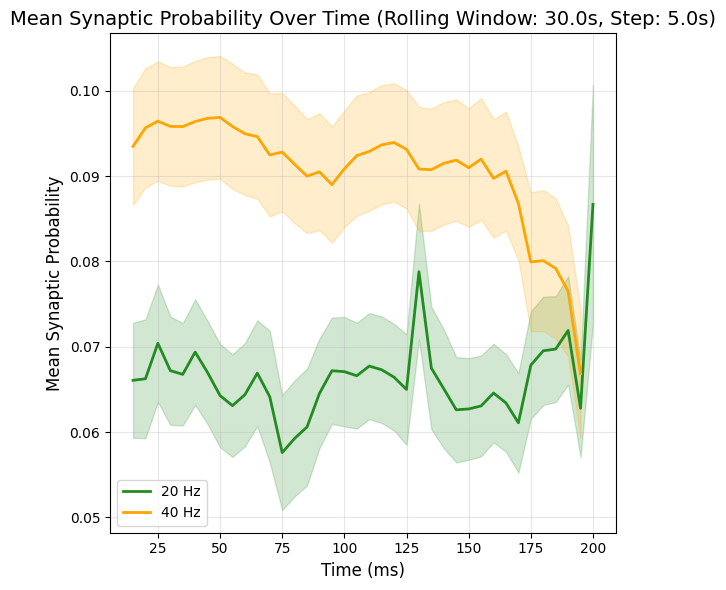

In [13]:
window_size = 30000
step_size = 5000
colors = ['forestgreen', 'orange']
 # Create and return the plot
fig, ax = plt.subplots(figsize=(6, 6))
for i, frequency in enumerate(frequencies_ltp):
    window_centers = all_window_centers[i+2]
    mean_probabilities = all_mean_probabilities[i+2]
    all_probabilities = all_all_probabilities[i+2]
    
   

    # Only plot windows that have valid data
    valid_indices = ~np.isnan(mean_probabilities)

    ax.plot(window_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            '-', color=colors[i], linewidth=2, label=f'{frequency} Hz')

    ax.set_xlabel('Time (ms)', fontsize=12)
    #ax.set_xlim(175, 210)
    #ax.set_ylim(0.05,0.20)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    #ax.set_ylim(0.1,0.3)
    ax.set_title(f'Mean Synaptic Probability Over Time (Rolling Window: {window_size/1000}s, Step: {step_size/1000}s)', 
                fontsize=14)
    ax.grid(True, alpha=0.3) 
    # Add confidence interval
    if np.sum(valid_indices) > 2:  # Only if we have enough data points
        sem = np.nanstd(all_probabilities, axis=0) / np.sqrt(np.sum(~np.isnan(all_probabilities), axis=0))
        sem = sem[valid_indices]
        ax.fill_between(
            window_centers[valid_indices]/1000,
            mean_probabilities[valid_indices] - sem,
            mean_probabilities[valid_indices] + sem,
            alpha=0.2,
            color=colors[i],
            #label='±1 SEM'
        )
    
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()

plt.show()

In [31]:
def calculate_synaptic_probability_over_time_end_handiling(all_latency, all_lag, bin_size=30000, label = '10 Hz'):
    """
    Calculate and plot the mean synaptic probability over time, binned in 30-second intervals.
    
    Parameters:
    -----------
    all_latency : pandas.Series
        Series where each element is a structured array with fields:
        ('input spike', '<i4'), ('spike time', '<f8'), ('latency', '<f4'), ('category', '<U6')
    all_lag : pandas.Series
        Series of lag values corresponding to each row in all_latency
    bin_size : int, default=30000
        Size of time bins in milliseconds (30 seconds)
    
    Returns:
    --------
    tuple
        (bin_centers, mean_probabilities, figure)
    """
    # Find the maximum spike time across all rows to determine the number of bins
    max_time = max(np.max(latency['spike time']) for latency in all_latency)
    num_bins = int(np.ceil(max_time / bin_size))
    bin_edges = np.arange(0, (num_bins + 1) * bin_size, bin_size)
    bin_centers = bin_edges[:-1] + bin_size/2
    
    # Initialize a 2D array to store probabilities per row per bin
    # (rows = different all_latency entries, columns = time bins)
    all_probabilities = np.full((len(all_latency), num_bins), np.nan)
    
    # 1) For each row in all_latency:
    for i in range(len(all_latency)):
        latency = all_latency[i]
        lag = all_lag[i]
        
        # 2) For each time bin:
        for bin_idx in range(num_bins):
            bin_start = bin_edges[bin_idx]
            bin_end = bin_edges[bin_idx+1]
            
            # Special handling for the last bin if it's a partial bin
            if bin_idx == num_bins - 1:
                bin_end = min(bin_end, max_time)
                
                # Skip if the bin is too small (less than half a normal bin)
                if bin_end - bin_start < bin_size / 2:
                    continue
            
            # Get spikes in this bin
            bin_mask = (latency['spike time'] >= bin_start) & (latency['spike time'] < bin_end)
            bin_latency = latency[bin_mask]
            
            # Skip if no spikes in this bin
            if len(bin_latency) == 0:
                continue
            
            # Skip if no input spikes in this bin
            input_spike_counts = np.sum(bin_latency['category'] == 'input')
            if input_spike_counts == 0:
                continue
                
            # Calculate synaptic probability using the provided formula
            data_output = bin_latency[bin_latency['category'] == 'output']
            latency_filtered = data_output[(data_output['latency'] >= lag - 1) & 
                                         (data_output['latency'] <= lag + 1)]
            
            input_spikes = bin_latency['input spike'][bin_latency['category'] == 'input']
            output_spike_counts = np.sum(np.isin(latency_filtered['input spike'], input_spikes))
            
            # Calculate probability and store it for this row and bin
            probability = output_spike_counts / input_spike_counts
            all_probabilities[i, bin_idx] = probability
    
    # 3) Calculate mean probability across rows for each time bin
    mean_probabilities = np.nanmean(all_probabilities, axis=0)
    
    # 4) Create and return the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Only plot bins that have valid data
    valid_indices = ~np.isnan(mean_probabilities)
    
    ax.plot(bin_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            'o-', color='royalblue', linewidth=2, markersize=6)
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    ax.set_title('Mean Synaptic Probability Over Time (30s bins)', fontsize=14)
    ax.grid(True, alpha=0.3)

    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    return bin_centers, mean_probabilities, fig

/tmp/ipykernel_26997/3192812062.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_26997/3192812062.py:74: RuntimeWarning: Mean of empty slice
  mean_probabilities = np.nanmean(all_probabilities, axis=0)


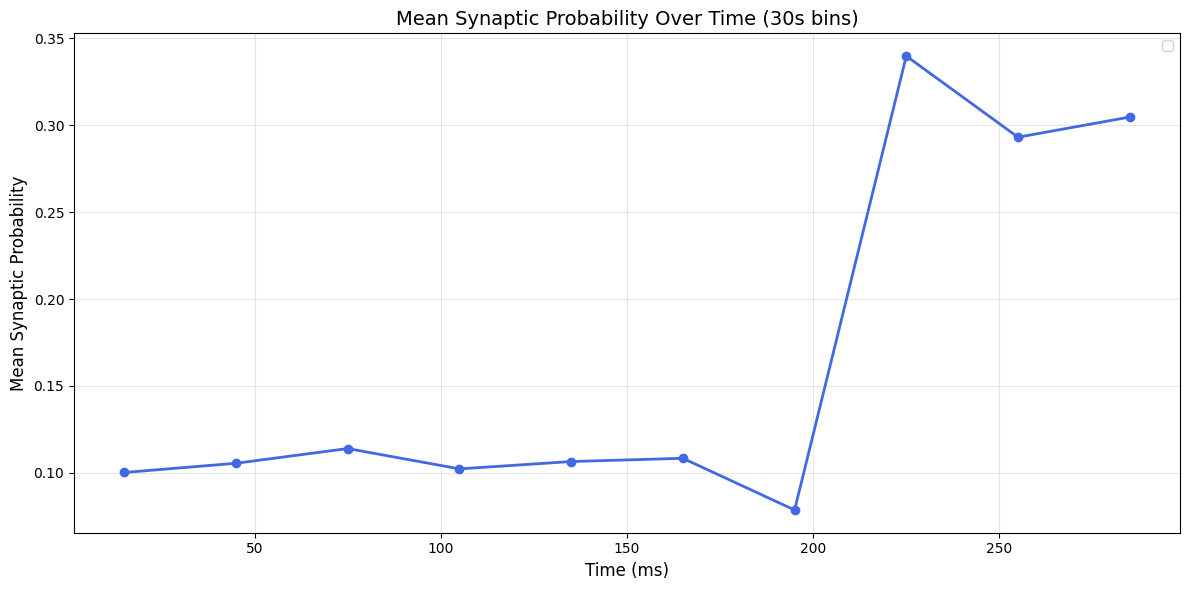

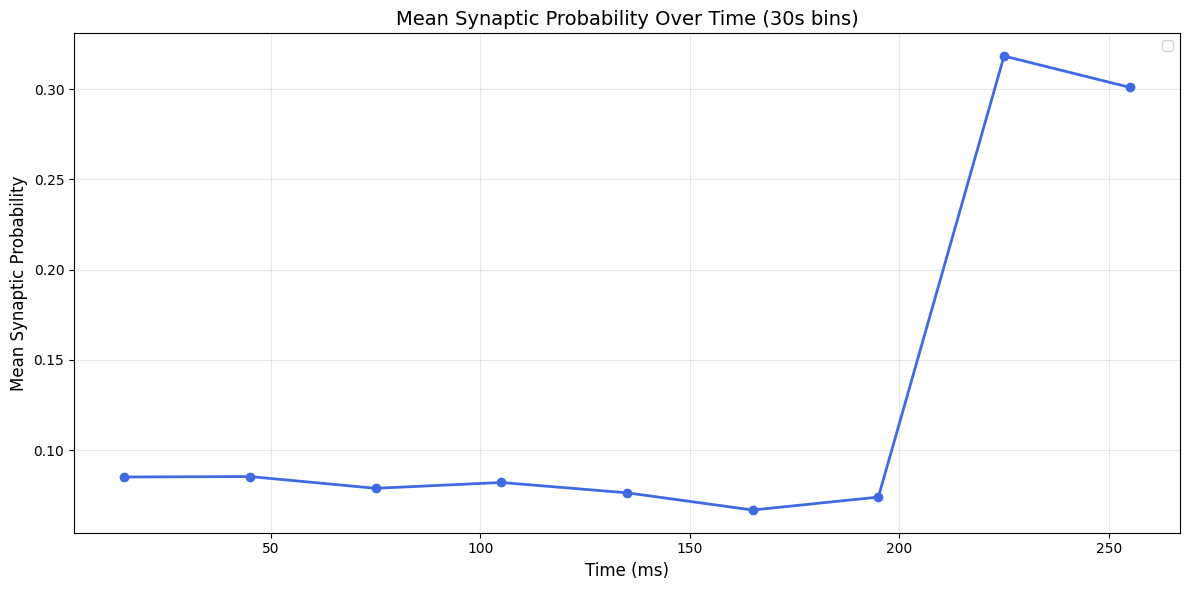

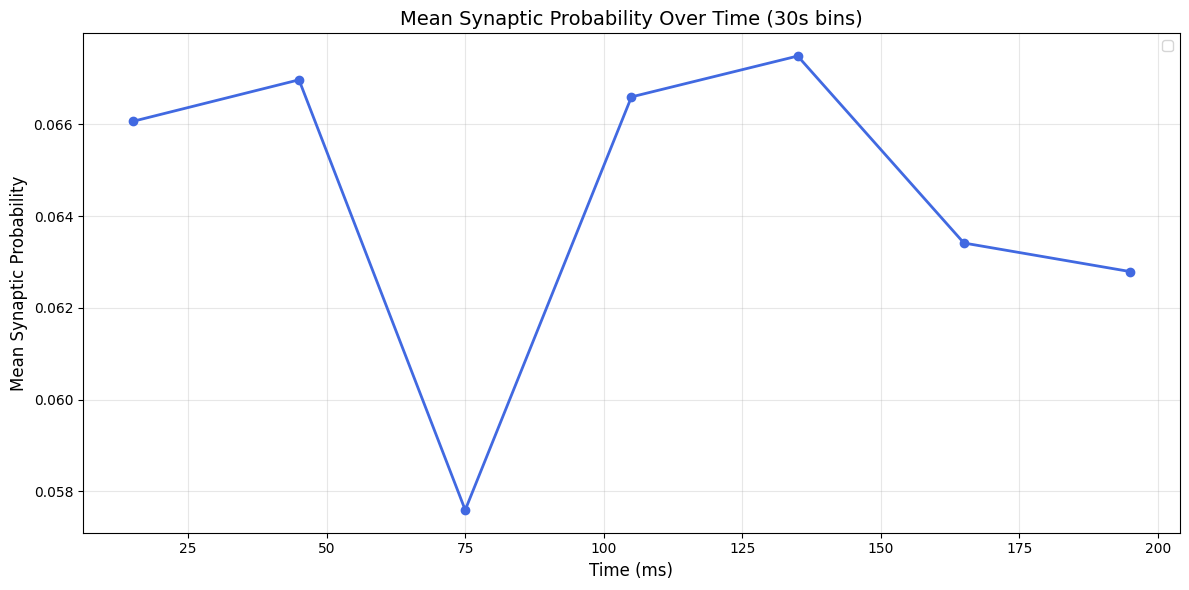

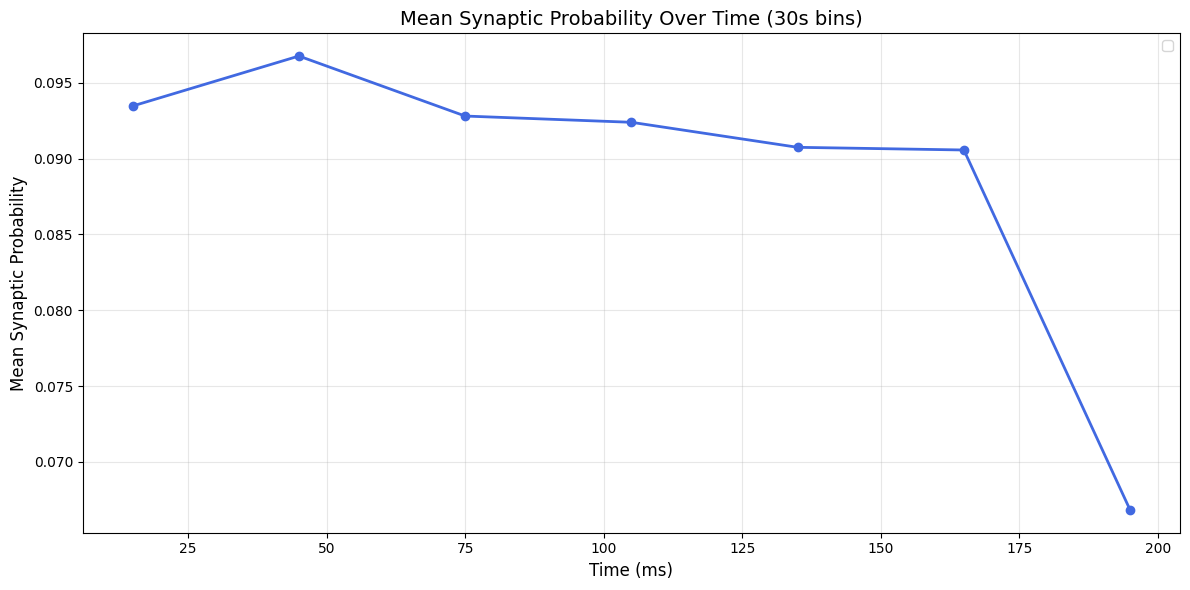

In [33]:
all_window_centers = []
all_mean_probabilities = []
all_all_probabilities = []
for frequency in frequencies:

    all_latency = all_data['latency_extremum'][(all_data['Stimulation_frequency'] == f'{frequency}_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'after')].copy()
    all_lag = all_data['lag'][(all_data['Stimulation_frequency'] == f'{frequency}_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'after')].copy()
    
    all_latency = all_latency.reset_index(drop=True)
    all_lag = all_lag.reset_index(drop=True)
    
    window_centers, mean_probabilities, fig = calculate_synaptic_probability_over_time_end_handiling(all_latency, all_lag, bin_size=30000, label = f'{frequency} Hz')
    all_mean_probabilities.append(mean_probabilities)
    all_all_probabilities.append(all_probabilities)


In [24]:
def calculate_synaptic_probability_rolling_window_v2(all_latency, all_lag, window_size=30000, step_size=5000, label = '10 Hz'):
    """
    Calculate and plot the mean synaptic probability over time using a rolling window approach.
    
    Parameters:
    -----------
    all_latency : pandas.Series
        Series where each element is a structured array with fields:
        ('input spike', '<i4'), ('spike time', '<f8'), ('latency', '<f4'), ('category', '<U6')
    all_lag : pandas.Series
        Series of lag values corresponding to each row in all_latency
    window_size : int, default=30000
        Size of the rolling window in milliseconds (30 seconds)
    step_size : int, default=5000
        Step size for moving the window in milliseconds (5 seconds)
    
    Returns:
    --------
    tuple
        (window_centers, mean_probabilities, figure)
    """
    # Find the maximum spike time across all rows
    max_time = max(np.max(latency['spike time']) for latency in all_latency)
    #max_time = 190000
    
    # Create rolling windows that cover the entire time range
    start_times = np.arange(0, max_time, step_size)
    window_centers = []
    
    for start in start_times:
        end = min(start + window_size, max_time)
        # Calculate the center based on actual window size
        window_centers.append(start + (end - start) / 2)
    
    window_centers = np.array(window_centers)
    num_windows = len(start_times)
    
    # Initialize array to store probabilities for each row and window
    all_probabilities = np.full((len(all_latency), num_windows), np.nan)
    
    # Process each row
    for i in range(len(all_latency)):
        latency = all_latency[i]
        lag = all_lag[i]
        
        # Process each window
        for w_idx, start_time in enumerate(start_times):
            end_time = min(start_time + window_size, max_time)
            
            # Skip if window is too small (less than half the normal window size)
            if end_time - start_time < window_size / 2:
                continue
            
            # Get spikes in this window
            window_mask = (latency['spike time'] >= start_time) & (latency['spike time'] < end_time)
            window_latency = latency[window_mask]
            
            if len(window_latency) == 0:
                continue
                
            input_spike_counts = np.sum(window_latency['category'] == 'input')
            if input_spike_counts == 0:
                continue
            
            # Calculate synaptic probability using the provided formula
            data_output = window_latency[window_latency['category'] == 'output']
            latency_filtered = data_output[(data_output['latency'] >= lag - 1) & 
                                         (data_output['latency'] <= lag + 1)]
            
            input_spikes = window_latency['input spike'][window_latency['category'] == 'input']
            output_spike_counts = np.sum(np.isin(latency_filtered['input spike'], input_spikes))
            
            # Calculate and store probability for this row and window
            probability = output_spike_counts / input_spike_counts
            all_probabilities[i, w_idx] = probability
    
    # Calculate mean probability across rows for each window
    mean_probabilities = np.nanmean(all_probabilities, axis=0)
    
    # Create and return the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Only plot windows that have valid data
    valid_indices = ~np.isnan(mean_probabilities)
    
    ax.plot(window_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            '-', color='royalblue', linewidth=2)
    
    #ax.set_ylim(0.05,0.2)
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    ax.set_title(f'Rolling Window: {window_size/1000}s, Step: {step_size/1000}s) for frequency {label}', 
                 fontsize=14)
    ax.grid(True, alpha=0.3)
    
    
    # Add confidence interval
    if np.sum(valid_indices) > 2:  # Only if we have enough data points
        sem = np.nanstd(all_probabilities, axis=0) / np.sqrt(np.sum(~np.isnan(all_probabilities), axis=0))
        sem = sem[valid_indices]
        
        ax.fill_between(
            window_centers[valid_indices]/1000,
            mean_probabilities[valid_indices] - sem,
            mean_probabilities[valid_indices] + sem,
            alpha=0.2,
            color='royalblue',
            label='±1 SEM'
        )
    
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    return window_centers, mean_probabilities, all_probabilities, fig

In [107]:
all_data['Chip_ID']

9        ID2184
16       ID2184
21       ID2184
22       ID2184
23       ID2184
          ...  
26282    ID2184
26285    ID2184
26288    ID2184
26290    ID2184
26312    ID2184
Name: Chip_ID, Length: 7516, dtype: object

In [108]:
filt_data_after = all_data[(all_data['Stimulation_frequency'] == f'5_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'after')]
filt_data_before = all_data[(all_data['Stimulation_frequency'] == f'5_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'before')]
print(len(filt_data_before))
filt_data_before = filt_data_before[
    filt_data_before[['source_electrode', 'target_electrode']].apply(
        tuple, axis=1
    ).isin(
        filt_data_after[['source_electrode', 'target_electrode']].apply(tuple, axis=1)
    )
]
filt_data_before

389


,source_electrode,target_electrode,source_unit_id,target_unit_id,lag,validation,mTE,syn probability,latency_extremum,electrodes_source_unit,...,source_firing_rate,target_firing_rate,source_isi_mean,target_isi_mean,source_isi_median,target_isi_median,source_isi_std,target_isi_std,source_isi_cv,target_isi_cv
771,2231,911,16,2,6.0,good,0.000384,0.051071,"[[0, 20.9, 0.0, input], [1, 48.2, 0.0, input],...","[3333, 911, 2895, 2015, 693, 2453, 1573, 3114,...",...,11.959472,7.546714,83.650185,132.594546,22.4,32.85,315.976648,507.070287,3.777357,3.824217
773,926,255,35,3,10.0,good,0.000676,0.022684,"[[0, 22.4, 0.0, input], [1, 24.95, 0.0, input]...","[1147, 2246, 1585, 924, 1808, 1806, 705, 2025,...",...,15.416984,8.123485,64.88426,123.174575,14.35,24.8,467.439387,1184.358884,7.204203,9.615287
774,2231,255,16,3,8.0,good,0.000462,0.048188,"[[0, 20.9, 0.0, input], [0, 27.95, 7.05, outpu...","[3333, 911, 2895, 2015, 693, 2453, 1573, 3114,...",...,11.959472,8.123485,83.650185,123.174575,22.4,24.8,315.976648,1184.358884,3.777357,9.615287
775,926,255,41,3,5.0,good,0.000420,0.081919,"[[0, 17.85, 0.0, input], [1, 33.2, 0.0, input]...","[1147, 2246, 1585, 924, 1808, 1806, 705, 2025,...",...,6.675306,8.123485,149.916507,123.174575,24.55,24.8,1352.054331,1184.358884,9.018716,9.615287
791,926,24023,35,19,8.0,good,0.000459,0.037380,"[[0, 22.4, 0.0, input], [1, 24.95, 0.0, input]...","[1147, 2246, 1585, 924, 1808, 1806, 705, 2025,...",...,15.416984,7.192157,64.88426,139.135641,14.35,36.7,467.439387,893.478398,7.204203,6.421636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24453,1523,1307,83,64,5.0,good,0.000375,0.043108,"[[0, 2.85, 0.0, input], [1, 10.35, 0.0, input]...","[1744, 2186, 1963, 3285, 4385, 645, 3725, 1085...",...,11.690469,3.988973,85.580308,251.039777,16.65,38.45,1311.584739,2884.428431,15.325777,11.489926
24454,1309,1307,56,64,4.0,good,0.000304,0.038369,"[[0, 6.2, 0.0, input], [1, 50.05, 0.0, input],...","[5053, 3729, 4171, 4832, 2632, 3509, 3731, 351...",...,9.147297,3.988973,109.387493,251.039777,22.65,38.45,1021.515831,2884.428431,9.338507,11.489926
24455,1309,1307,55,64,6.0,good,0.000374,0.029796,"[[0, 30.200000000000003, 0.0, input], [1, 44.7...","[5053, 3729, 4171, 4832, 4389, 3509, 3731, 351...",...,13.473676,3.988973,74.249102,251.039777,23.45,38.45,510.858928,2884.428431,6.880338,11.489926
24464,1523,1958,83,77,1.0,good,0.000773,0.086215,"[[0, 2.85, 0.0, input], [1, 10.35, 0.0, input]...","[1744, 2186, 1963, 3285, 4385, 645, 3725, 1085...",...,11.690469,10.044182,85.580308,99.614352,16.65,22.95,1311.584739,602.7461,15.325777,6.050796


Frequency 5 contains filenames ['ID2184_5_DIV41_DATE20250424_1301_spontaneous_FreqVarDel5V2_.raw_processed_info_metrics.pkl'
 'ID2184_1_DIV35_DATE20250418_1419_spontaneous_FreqVar5ms.raw_processed_info_metrics.pkl'
 'ID2184_3_DIV46_DATE20250429_1457_spontaneous_FreqVarDel5V2_.raw_processed_info_metrics.pkl']
41


/tmp/ipykernel_23980/2576806087.py:78: RuntimeWarning: Mean of empty slice
  mean_probabilities = np.nanmean(all_probabilities, axis=0)
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


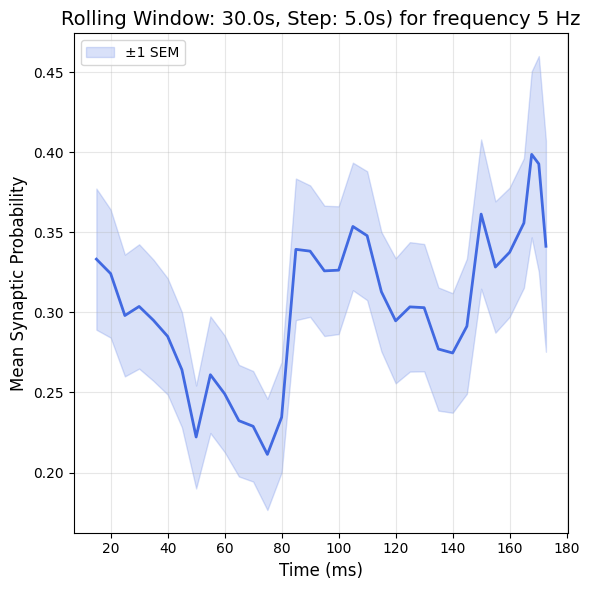

In [25]:
all_window_centers = []
all_mean_probabilities = []
all_all_probabilities = []
for frequency in frequencies:
    filt_data = all_data[(all_data['Stimulation_frequency'] == f'{frequency}_Hz') & (all_data['Delay'] == '5_ms') & (all_data['Status'] == 'after')]
    filt_data = filt_data[filt_data['Chip_ID'] == 'ID2184']
    #filt_data_after = all_data[(all_data['Stimulation_frequency'] == f'{frequency}_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'after')]
    #filt_data_after = filt_data_after[filt_data_after['Chip_ID'] == 'ID2184']
    #filt_data_before = all_data[(all_data['Stimulation_frequency'] == f'5_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'before')]
    #print(len(filt_data_before))
    #filt_data_before = filt_data_before[
    #    filt_data_before[['source_electrode', 'target_electrode']].apply(
    #        tuple, axis=1
    #    ).isin(
    #        filt_data_after[['source_electrode', 'target_electrode']].apply(tuple, axis=1)
    #    )
    #]
    
    all_latency = filt_data['latency_extremum']
    all_lag = filt_data['lag']
    print(f"Frequency {frequency} contains filenames {filt_data['filename'].unique()}")
    print(len(all_latency))
    all_latency = all_latency.reset_index(drop=True)
    all_lag = all_lag.reset_index(drop=True)

   

    
    window_centers, mean_probabilities, all_probabilities, fig = calculate_synaptic_probability_rolling_window_v2(all_latency, all_lag, window_size=30000, step_size = 5000, label = f'{frequency} Hz')
    all_mean_probabilities.append(mean_probabilities)
    all_window_centers.append(window_centers)
    all_all_probabilities.append(all_probabilities)

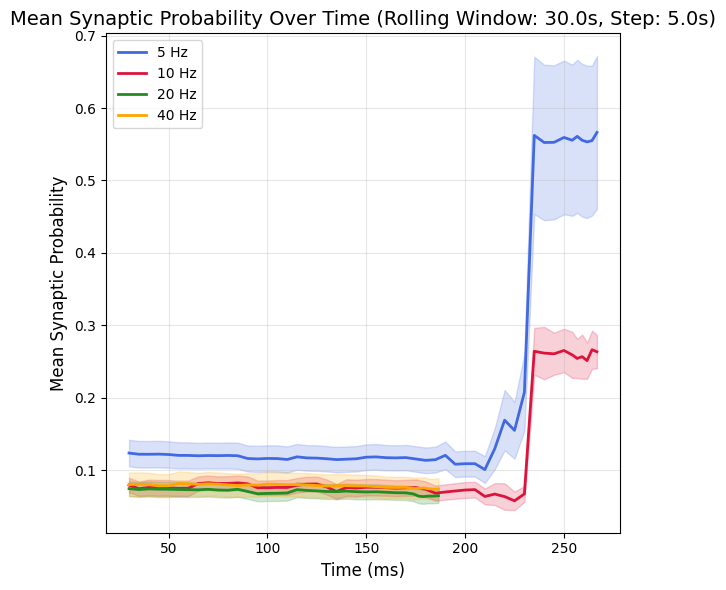

In [121]:
window_size = 30000
step_size = 5000
colors = ['royalblue', 'crimson', 'forestgreen', 'orange']
 # Create and return the plot
fig, ax = plt.subplots(figsize=(6, 6))
for i, frequency in enumerate(frequencies):
    window_centers = all_window_centers[i]
    mean_probabilities = all_mean_probabilities[i]
    all_probabilities = all_all_probabilities[i]
    
   

    # Only plot windows that have valid data
    valid_indices = ~np.isnan(mean_probabilities)

    ax.plot(window_centers[valid_indices]/1000, mean_probabilities[valid_indices], 
            '-', color=colors[i], linewidth=2, label=f'{frequency} Hz')

    ax.set_xlabel('Time (ms)', fontsize=12)
    #ax.set_xlim(175, 210)
    #ax.set_ylim(0.05,0.40)
    ax.set_ylabel('Mean Synaptic Probability', fontsize=12)
    #ax.set_ylim(0.1,0.3)
    ax.set_title(f'Mean Synaptic Probability Over Time (Rolling Window: {window_size/1000}s, Step: {step_size/1000}s)', 
                fontsize=14)
    ax.grid(True, alpha=0.3) 
    # Add confidence interval
    if np.sum(valid_indices) > 2:  # Only if we have enough data points
        sem = np.nanstd(all_probabilities, axis=0) / np.sqrt(np.sum(~np.isnan(all_probabilities), axis=0))
        sem = sem[valid_indices]
        ax.fill_between(
            window_centers[valid_indices]/1000,
            mean_probabilities[valid_indices] - sem,
            mean_probabilities[valid_indices] + sem,
            alpha=0.2,
            color=colors[i],
            #label='±1 SEM'
        )
    
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    
    plt.tight_layout()

plt.show()

In [69]:
frequency = 10
a = all_data[(all_data['Stimulation_frequency'] == f'{frequency}_Hz') & (all_data['Delay'] == '0_ms') & (all_data['Status'] == 'after')]
a

,source_electrode,target_electrode,source_unit_id,target_unit_id,lag,validation,mTE,syn probability,latency_extremum,electrodes_source_unit,...,source_firing_rate,target_firing_rate,source_isi_mean,target_isi_mean,source_isi_median,target_isi_median,source_isi_std,target_isi_std,source_isi_cv,target_isi_cv
10161,13087,20566,64,53,3.0,good,0.001277,0.080214,"[[0, 314.45, 0.0, input], [0, 315.35, 0.9, out...","[13087, 14186, 13525, 13747, 12866, 13965, 144...",...,3.079387,0.387998,325.319821,2614.683333,60.825,947.1,758.670762,3181.593736,2.332077,1.216818
10169,15727,20566,44,70,4.0,good,0.002364,0.942857,"[[0, 3641.9, 0.0, input], [0, 3646.39999999999...","[18807, 14407, 16387, 23207, 16606, 15725, 177...",...,0.618331,1.189183,1632.808173,844.879953,655.025,590.975,5567.912905,907.647405,3.410023,1.074292
10170,13087,20566,64,70,5.0,good,0.000483,0.080214,"[[0, 314.45, 0.0, input], [1, 643.9, 0.0, inpu...","[13087, 14186, 13525, 13747, 12866, 13965, 144...",...,3.079387,1.189183,325.319821,844.879953,60.825,590.975,758.670762,907.647405,2.332077,1.074292
10187,11765,18804,34,49,4.0,good,0.003252,0.633028,"[[0, 2850.65, 0.0, input], [1, 4884.7, 0.0, in...","[5603, 8023, 10005, 9123, 9565, 10447, 10887, ...",...,0.605803,0.468906,1665.984722,2159.620253,1327.875,1410.7,1229.423683,1924.414342,0.737956,0.891089
11071,24352,22813,5,32,2.0,good,0.000746,0.741935,"[[0, 621.6500000000001, 0.0, input], [0, 623.7...","[21274, 21050, 20835, 21934, 24353, 22374, 241...",...,0.536299,3.407478,1884.899457,293.954852,1397.45,139.325,3047.499499,486.674666,1.616797,1.65561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20380,1523,21767,77,25,2.0,good,0.000361,0.065032,"[[0, 32.4, 0.0, input], [1, 116.65, 0.0, input...","[1744, 2186, 1963, 2847, 3285, 3725, 2407, 108...",...,5.044828,4.039222,198.434365,247.902533,26.0,38.1,2197.624055,2683.9807,11.074816,10.826758
20381,1073,21767,44,25,9.0,good,0.000297,0.045568,"[[0, 17.45, 0.0, input], [1, 66.8, 0.0, input]...","[3054, 1073, 1517, 858, 2396, 1515, 3494, 2173...",...,6.489191,4.039222,154.230182,247.902533,25.25,38.1,1481.092901,2683.9807,9.603133,10.826758
20385,1309,1743,59,79,3.0,good,0.000093,0.018378,"[[0, 49.35, 0.0, input], [0, 53.1, 3.75, outpu...","[3729, 4171, 4832, 4389, 2632, 3509, 3731, 351...",...,13.459569,4.469656,74.326279,224.000422,20.675,121.2,503.98987,294.476361,6.780776,1.314624
20394,25502,3729,10,22,4.0,good,0.000288,0.030984,"[[0, 27.2, 0.0, input], [0, 30.95, 3.75, outpu...","[25061, 22862, 23081, 23304, 23523, 24184, 250...",...,6.943475,2.495937,144.131744,401.516415,25.3,138.75,1678.477269,637.849513,11.645438,1.588601
